# This notebook summarizes the evolution code
## It aims to standarize the function definition with standard data output and input

In [1]:
import numpy as np
import random
import math
# from numba import jit
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import pickle
import os
import copy
from concurrent.futures import ProcessPoolExecutor
%autosave 10

Autosaving every 10 seconds


In [32]:
# evolution function definition
# birth=[0,1,2,3,4]
class agent:
    """
    Agent class encapsulates the information about the position and phenotpye of the agent as well as the agent's current birth and relocation rate.
        
        Parameters:
            h1 to h5 (float): relocation rate or hopping rate of the agent at resource level 1 to 5, which comprises the agent's phenotype
            x, y (int): the x and y coordinate of the agent's location in the 2-dimensional environment
        Functions:
            updatepos(x,y): update the agent's location to (x,y)
    """
    def __init__(self,hop,x,y):

        self.hop = hop
        self.pos = (x,y)
        self.birth = [0,1,2,3,b5]
        self.b = self.birth[int(resource[x,y])]  # resource goes as 0, 1, 2, 3, 4
        self.h = self.hop[int(resource[x,y])] 

    def updatepos(self,x,y):
        self.pos = (x,y)
        self.b = self.birth[int(resource[x,y])] # resource goes as 0, 1, 2, 3, 4
        self.h = self.hop[int(resource[x,y])]        
        

def get_num(a,n): 
    """
    Efficiently count agent numbers at all the sites
     
        Parameters: 
            a (list or array): list of agent object;
            n (int): size of the square environment
        Return:
            2-d numpy array: entry at i,j represents the number of agent at location (i,j)
    """
    num=np.zeros((n,n),dtype=int)
    for pos in [a[i].__dict__['pos'] for i in range(len(a))]:
        num[pos]+=1
    return num


def get_i(x,arr,l,r):
    """
    Binary search for the index of an element in a sorted list
        
        Parameters:
            x (float): target to be located for
            arr (list or numpy array): a sorted list where the target will be located at
            l (int): left pointer, usually start with 0
            r (int): right pointer, usually start with len(a)
        Return:
            i (int): index that arr[i]<=x<=arr[i+1]
    """
    if x <= arr[0]:
        return 0
    else:
        while l <= r: 
            mid = l + int((r - l)/2); 
            # Check if x is present at mid 
            if arr[mid] < x and arr[mid+1] >= x: 
                return mid+1 
            # If x is greater, ignore left half 
            elif arr[mid+1] < x: 
                l = mid + 1
            # If x is smaller, ignore right half 
            else: 
                r = mid 
        raise Exception("Target not found")

def uniform_resource(x,y):
    """Return a uniformly generated 2-dimensional numpy array representing the resource level at each site"""
    return np.random.choice([0,1,2,3,4], size=(x,y))

def exponetial_resource(x,y,c):
    p = [np.exp(-i*c) for i in range(1,6)]
    p = p/np.sum(p)
    return np.random.choice([0,1,2,3,4],size=(x,y),p=p)

def intialcondtiongenerator_uniform(hop_high=10, n=128, m=500):
    """Generate a list of agents from uniformly chosen hopping rates and locations; locations are chosen without replacement
    """
    pos=np.array([[i//n,i%n] for i in np.random.choice(n*n,m,replace=False)])
    return [agent(hop,x,y) for hop,x,y in zip(np.random.uniform(0,hop_high,(m,5)),pos[:,0],pos[:,1])]
    
def evolve(total_iteration,  initial_condition,trialnumber, n = 128,noisestd = 0.01, datastoretype=100, 
           initialagentnumber=500, T=0.3,K = 1, hop_high = 10,note=None,b5=4,c=0):
#     _path = './evolve_data'+'/{}'.format(time.strftime("%Y_%m_%d_%H_%M",time.localtime()))+'/trial_{}'.format(trialnumber)
    _path = './evolve_data/b5_c_plane'+'/b5_{}_c_{}'.format(b5,c)+'/trial_{}'.format(trialnumber)

    os.makedirs(_path,exist_ok=True)
    info = {"lattice": "{}*{}".format(n,n), "total_iteartion": total_iteration, "evolve_time": T, "noise":noisestd, "carrying_capacity": K, "initial_angent_number":initialagentnumber, "data_stored_every":datastoretype,"note":note}
    with open(_path+'/simulation_info.txt', "wb") as fp: 
        pickle.dump(info, fp)
    with open(_path+'/resource.txt', "wb") as fp: 
        pickle.dump(resource, fp)
        
    a = copy.deepcopy(initial_condition)
    with open(_path+'/iteration_00', "wb") as fp: 
        pickle.dump(a, fp)
    for iteration in range(total_iteration):
        t = 0
        num = get_num(a,n)
        br = [a[i].b for i in range(len(a))]
        hr = [a[i].h for i in range(len(a))]
        brsum = sum(br)
        w = brsum + sum(hr) # total rates
        
        br_cumsum=np.cumsum(br)
        hr_cumsum=np.cumsum(hr)
        while t < T: 
            
           
            dt = -math.log(random.uniform(0.0,1.0)) / w
            t = t + dt
            r = w * random.uniform(0.0,1.0)

            if r < brsum:
                 # birth
                i = get_i(r,br_cumsum,0,len(a)-1)
                hop_advance=[[1,0],[0,1],[-1,0],[0,-1]][np.random.randint(0,4)]
                pos_new=(np.array(a[i].pos)+np.array(hop_advance))%n

                if num[pos_new[0],pos_new[1]] < K:
                    noise = np.random.normal(0, noisestd, 5)
                    hop_new = np.clip(np.array(a[i].hop)+noise,0,hop_high)

                    a.append(agent(hop_new,pos_new[0],pos_new[1]))                     
                    num[pos_new[0],pos_new[1]] +=1
                    br.append(a[-1].b)
                    hr.append(a[-1].h)
                    brsum+=a[-1].b
                    w+=a[-1].b+a[-1].h
                    br_cumsum=np.append(br_cumsum,a[-1].b+br_cumsum[-1])
                    hr_cumsum=np.append(hr_cumsum,a[-1].h+hr_cumsum[-1])
                    
    
            else:
                # hopping
                i = get_i(r,brsum+hr_cumsum,0,len(a)-1);

                hop_advance=[[1,0],[0,1],[-1,0],[0,-1]][np.random.randint(0,4)]
                pos_new=(np.array(a[i].pos)+np.array(hop_advance))%n
    
                if num[pos_new[0],pos_new[1]] < K:
    
                    num[pos_new[0],pos_new[1]]+=1
                    num[a[i].pos[0],a[i].pos[1]]-=1
                    a[i].updatepos(pos_new[0],pos_new[1])
                    brsum+=a[i].b-br[i]
                    w+=a[i].b-br[i]+a[i].h-hr[i]
                    br_cumsum[i:]+=a[i].b-br[i]
                    hr_cumsum[i:]+=a[i].h-hr[i]
                    br[i]=a[i].b
                    hr[i]=a[i].h

        if len(a) > initialagentnumber:
#             print(len(a))
            reset = random.sample(range(len(a)), initialagentnumber) # randomly generate m agents to keep for the next iteration
            a = [a[i] for i in reset]
            
        if iteration%datastoretype == 0:
            with open(_path+'/iteration_{}'.format(iteration), "wb") as fp: 
                pickle.dump(a, fp)
        
    return a


In [ ]:
for c in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]:
    resource = exponetial_resource(128,128,c)
    for b5 in [3,4,5,6,7,8,9,10]:
        print(c,b5)
        with ProcessPoolExecutor() as executor:
            test = [executor.submit(evolve,total_iteration=20001,initial_condition=intialcondtiongenerator_uniform(hop_high=10, n=128, m=500),trialnumber=i,n = 128, noisestd = 0.05, datastoretype=1000, 
           initialagentnumber=500, T=0.3,K = 1, hop_high = 10,note='standard parameters (further optimized algorithm) 5rd run: uniform resource initial 500 agents, 5 resource levels, [0,1,2,3,4], 128*128 sites, T=0.3 k=1',b5=b5,c=c) for i in range(20)]


0 3
0 4
0 5
0 6


In [15]:
# iteration =20000
# var=[[] for _ in range(len(range(0,iteration,200)))]
ave=[[] for _ in range(len(range(0,iteration,200)))]
for c in [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]:
    for b5 in [3,4,5,6,7,8,9,10]:
        for i in range(20):
            data=[[] for _ in range(20)]
            try:
                with open("./evolve_data/b5_c_plane/b5_{}_c_{}/trial_{}/iteration_{}".format(b5,c,i,20000), "rb") as fp:   # Unpickling
                    data[i] = pickle.load(fp)
            except FileNotFoundError:
                print("trial_{}".format(j)+" doesn\'t have iteration_{}".format(i))
            else:
                boxdata.append(np.average(np.array([data[i][j].hop for j in range(500)]),axis=0))
#     boxdata=[np.median(np.array([data[j][i].hop for i in range(500)]),axis=0) for j in range(20)]
        var[int(i/200)]=np.var(np.array(boxdata).T,1)
        ave[int(i/200)]=np.average(np.array(boxdata).T,1)

[0, 1, 2, 3, 8]

In [34]:
c=0.1
b5=8
boxdata=[]
for i in range(20):
    try:
        with open("./evolve_data/b5_c_plane/b5_{}_c_{}/trial_{}/iteration_{}".format(b5,c,i,20000), "rb") as fp:   # Unpickling
            data = pickle.load(fp)
    except FileNotFoundError:
        print("trial_{}".format(j)+" doesn\'t have iteration_{}".format(i))
    else:
        boxdata.append(np.average(np.array([data[j].hop for j in range(500)]),axis=0))

In [20]:
# with open('./evolve_data/2021_04_08_14_50/trail_19/resource.txt', "rb") as fp: 
#     resource=pickle.load(fp)
# b5=4
b=intialcondtiongenerator_uniform(hop_high=10, n=128, m=500)
a=evolve(total_iteration=1,initial_condition=b,trialnumber=0);

In [24]:
b5=4
with ProcessPoolExecutor() as executor:
    test = [executor.submit(evolve,total_iteration=20001,initial_condition=intialcondtiongenerator_uniform(hop_high=10, n=128, m=500),trialnumber=i,n = 128, noisestd = 0.05, datastoretype=200, 
           initialagentnumber=500, T=0.3,K = 1, hop_high = 10,note='standard parameters (further optimized algorithm) 5rd run: uniform resource initial 500 agents, 5 resource levels, [0,1,2,3,4], 128*128 sites, T=0.3 k=1') for i in range(20)]
# test= evolve(total_iteration=100,initial_condition=intialcondtiongenerator(_type = 'uniform',hop_high=10, n=128, m=500),trailnumber=0, noisestd = 0.05, datastoretype=1, 
#            initialagentnumber=500, T=0.002,K = 1, hop_high = 10,note='speed test')
# evolve(10,intialcondtiongenerator(_type = 'uniform',hop_high=10, n=128, m=500),0)

In [9]:
with open('./evolve_data/2021_04_08_14_50/trail_19/resource.txt', "rb") as fp: 
    resource=pickle.load(fp)
with ProcessPoolExecutor() as executor:
    test = [executor.submit(evolve,total_iteration=20001,initial_condition=intialcondtiongenerator_uniform(hop_high=10, n=128, m=500),trialnumber=i,n = 128, noisestd = 0.05, datastoretype=200, 
           initialagentnumber=500, T=0.3,K = 1, hop_high = 10,note='standard parameters (further optimized algorithm) 5rd run: uniform resource initial 500 agents, 5 resource levels, [0,1,2,3,4], 128*128 sites, T=0.3 k=1') for i in range(8)]


Process ForkProcess-34:
Process ForkProcess-27:
Process ForkProcess-39:
Process ForkProcess-33:
Process ForkProcess-30:
Process ForkProcess-41:
Process ForkProcess-50:
Process ForkProcess-29:
Process ForkProcess-36:
Process ForkProcess-42:
Process ForkProcess-52:
Process ForkProcess-32:
Process ForkProcess-31:
Process ForkProcess-48:
Process ForkProcess-35:
Process ForkProcess-51:
Process ForkProcess-43:
Process ForkProcess-38:
Process ForkProcess-24:
Process ForkProcess-44:
Process ForkProcess-28:
Process ForkProcess-54:
Process ForkProcess-25:
Process ForkProcess-55:
Process ForkProcess-47:
Process ForkProcess-53:
Process ForkProcess-37:
Process ForkProcess-13:
Process ForkProcess-40:
Process ForkProcess-26:
Process ForkProcess-49:
Process ForkProcess-16:
Process ForkProcess-56:
Process ForkProcess-11:
Process ForkProcess-45:
Process ForkProcess-12:
Process ForkProcess-18:
Process ForkProcess-23:
Process ForkProcess-20:
Process ForkProcess-22:
Process ForkProcess-46:
Process ForkProc

  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tong/a

  File "/home/tong/anaconda3/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/tong/anaconda3/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/tong/anaconda3/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tong/anaconda3/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/tong/anaconda3/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(block=True)
  File "/home/tong/anaconda3/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.

  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/queues.py", line 

KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
Keyboard

KeyboardInterrupt: 

Process ForkProcess-3:
Process ForkProcess-4:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process ForkProcess-2:
Process ForkProcess-1:
Process ForkProcess-5:
Process ForkProcess-6:
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/tong/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkProcess-7:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tong/anaconda3/lib/python3.7/concurrent/futures/process.py", line 233, in _process_worker
    call_item = call_queue.get(bloc

In [13]:
# multiprocessing

from concurrent.futures import ProcessPoolExecutor
with ProcessPoolExecutor() as executor:
    new = [executor.submit(evolve,total_iteration=20001,initial_condition=intialcondtiongenerator(_type = 'uniform',hop_high=10, n=128, m=500),trailnumber=i, noisestd = 0.05, datastoretype=50, 
           initialagentnumber=500, T=0.3,K = 1, hop_high = 10,note='6 resource levels, 0-5, uniform initial condition, noise 0.05, to test how does a new added phenotype component change the optimal phenotype combinations') for i in range(20)]


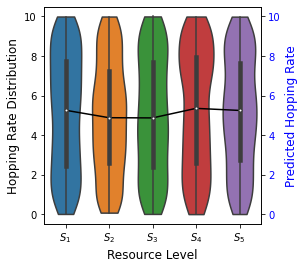

In [49]:
with open("./evolve_data/b5_c_plane/b5_10_c_0.7/trial_{}/iteration_{}".format(1,00), "rb") as fp:   # Unpickling
    data = pickle.load(fp)
plotsingleviolin(data)

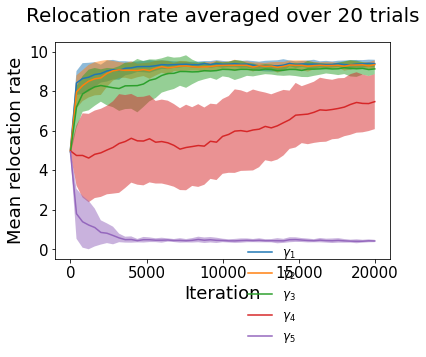

In [23]:
# iteration =10001
# var=[[] for _ in range(len(range(0,iteration,200)))]
# ave=[[] for _ in range(len(range(0,iteration,200)))]
# for i in range(0,iteration,200):
#     data=[[] for _ in range(20)]

#     boxdata=[]
#     for j in range(20):
# #         with open("./evolve_data/2020_06_17_01_25/trail_{}/iteration_{}".format(j,i), "rb") as fp:   # Unpickling
# #             data[j] = pickle.load(fp)
#         try:
#             with open("./evolve_data/2021_04_13_22_04/trial_{}/iteration_{}".format(j,i), "rb") as fp:   # Unpickling
#                 data[j] = pickle.load(fp)
#         except FileNotFoundError:
#             print("trail_{}".format(j)+" doesn\'t have iteration_{}".format(i))
#         else:
#             boxdata.append(np.average(np.array([data[j][i].hop for i in range(500)]),axis=0))
# #     boxdata=[np.median(np.array([data[j][i].hop for i in range(500)]),axis=0) for j in range(20)]
#     var[int(i/200)]=np.var(np.array(boxdata).T,1)
#     ave[int(i/200)]=np.average(np.array(boxdata).T,1)
# for i in range(5):    
#     plt.plot(np.sqrt(np.array(var))[:,i],label="component {}".format(i+1))
# plt.ylabel('STD of the medians of 20 copies')   
# plt.xlabel('Iterations/50')
# # plt.title('noise 0.05 uniform local birth')
# plt.legend()
# plt.show()
for i in range(5):    
    plt.plot(np.linspace(0,20000,51),np.array(ave)[:,i],'-',label="$\gamma_{}$".format(i+1))
    plt.fill_between(np.linspace(0,20000,51),np.array(ave)[:,i]-np.sqrt(np.array(var))[:,i], np.array(ave)[:,i]+np.sqrt(np.array(var))[:,i], alpha=0.5)
plt.ylabel('Mean relocation rate',fontsize = 18)   
plt.xlabel('Iteration',fontsize =18 )
# plt.xticks(fontsize=12)
# plt.title('Relocation rate averaged over 20 trials',fontsize=18)
plt.text(10000, 11.5, 'Relocation rate averaged over 20 trials',
         horizontalalignment='center',
         fontsize=20)
# plt.title('0 1 2 3 4 k =1 32*32 site')
plt.legend(bbox_to_anchor=(0.75, 0.11),frameon=False,fontsize=12)
plt.ylim(-0.5,10.5)
plt.gca().set_xticks([0,5000,10000,15000,20000])
plt.gca().tick_params(axis='x',labelsize=15)
plt.gca().tick_params(axis='y',labelsize=15)
# plt.legend()
# plt.show()
# plt.savefig('./Paper_1_Figures/evo_iteration_density0_ave.pdf')

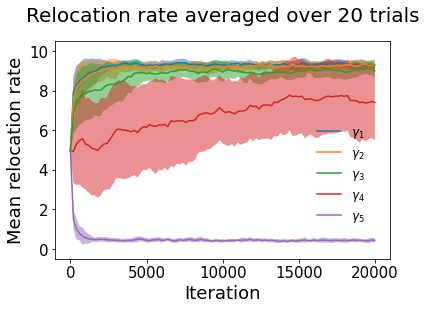

In [25]:
iteration =20001
var=[[] for _ in range(len(range(0,iteration,200)))]
ave=[[] for _ in range(len(range(0,iteration,200)))]
for i in range(0,iteration,200):
    data=[[] for _ in range(20)]

    boxdata=[]
    for j in range(20):
#         with open("./evolve_data/2020_06_17_01_25/trail_{}/iteration_{}".format(j,i), "rb") as fp:   # Unpickling
#             data[j] = pickle.load(fp)
        try:
            with open("./evolve_data/2021_04_13_22_49/trial_{}/iteration_{}".format(j,i), "rb") as fp:   # Unpickling
                data[j] = pickle.load(fp)
        except FileNotFoundError:
            print("trail_{}".format(j)+" doesn\'t have iteration_{}".format(i))
        else:
            boxdata.append(np.average(np.array([data[j][i].hop for i in range(500)]),axis=0))
#     boxdata=[np.median(np.array([data[j][i].hop for i in range(500)]),axis=0) for j in range(20)]
    var[int(i/200)]=np.var(np.array(boxdata).T,1)
    ave[int(i/200)]=np.average(np.array(boxdata).T,1)
# for i in range(5):    
#     plt.plot(np.sqrt(np.array(var))[:,i],label="component {}".format(i+1))
# plt.ylabel('STD of the medians of 20 copies')   
# plt.xlabel('Iterations/50')
# # plt.title('noise 0.05 uniform local birth')
# plt.legend()
# plt.show()
for i in range(5):    
    plt.plot(np.linspace(0,20000,101),np.array(ave)[:,i],'-',label="$\gamma_{}$".format(i+1))
    plt.fill_between(np.linspace(0,20000,101),np.array(ave)[:,i]-np.sqrt(np.array(var))[:,i], np.array(ave)[:,i]+np.sqrt(np.array(var))[:,i], alpha=0.5)
plt.ylabel('Mean relocation rate',fontsize = 18)   
plt.xlabel('Iteration',fontsize =18 )
# plt.xticks(fontsize=12)
# plt.title('Relocation rate averaged over 20 trials',fontsize=18)
plt.text(10000, 11.5, 'Relocation rate averaged over 20 trials',
         horizontalalignment='center',
         fontsize=20)
# plt.title('0 1 2 3 4 k =1 32*32 site')
plt.legend(bbox_to_anchor=(0.75, 0.11),frameon=False,fontsize=12)
plt.ylim(-0.5,10.5)
plt.gca().set_xticks([0,5000,10000,15000,20000])
plt.gca().tick_params(axis='x',labelsize=15)
plt.gca().tick_params(axis='y',labelsize=15)
# plt.legend()
# plt.show()
# plt.savefig('./Paper_1_Figures/evo_iteration_density0_ave.pdf')

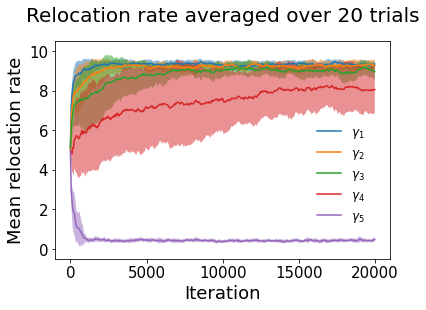

In [109]:
iteration =20001
var=[[] for _ in range(len(range(0,iteration,50)))]
ave=[[] for _ in range(len(range(0,iteration,50)))]
for i in range(0,iteration,50):
    data=[[] for _ in range(20)]

    boxdata=[]
    for j in range(20):
#         with open("./evolve_data/2020_06_17_01_25/trail_{}/iteration_{}".format(j,i), "rb") as fp:   # Unpickling
#             data[j] = pickle.load(fp)
        try:
            with open("./evolve_data/2021_04_08_21_48/trial_{}/iteration_{}".format(j,i), "rb") as fp:   # Unpickling
                data[j] = pickle.load(fp)
        except FileNotFoundError:
            print("trail_{}".format(j)+" doesn\'t have iteration_{}".format(i))
        else:
            boxdata.append(np.average(np.array([data[j][i].hop for i in range(500)]),axis=0))
#     boxdata=[np.median(np.array([data[j][i].hop for i in range(500)]),axis=0) for j in range(20)]
    var[int(i/50)]=np.var(np.array(boxdata).T,1)
    ave[int(i/50)]=np.average(np.array(boxdata).T,1)

for i in range(5):    
    plt.plot(np.linspace(0,20000,401),np.array(ave)[:,i],'-',label="$\gamma_{}$".format(i+1))
    plt.fill_between(np.linspace(0,20000,401),np.array(ave)[:,i]-np.sqrt(np.array(var))[:,i], np.array(ave)[:,i]+np.sqrt(np.array(var))[:,i], alpha=0.5)
plt.ylabel('Mean relocation rate',fontsize = 18)   
plt.xlabel('Iteration',fontsize =18 )
# plt.xticks(fontsize=12)
# plt.title('Relocation rate averaged over 20 trials',fontsize=18)
plt.text(10000, 11.5, 'Relocation rate averaged over 20 trials',
         horizontalalignment='center',
         fontsize=20)
# plt.title('0 1 2 3 4 k =1 32*32 site')
plt.legend(bbox_to_anchor=(0.75, 0.11),frameon=False,fontsize=12)
plt.ylim(-0.5,10.5)
plt.gca().set_xticks([0,5000,10000,15000,20000])
plt.gca().tick_params(axis='x',labelsize=15)
plt.gca().tick_params(axis='y',labelsize=15)
# plt.legend()
# plt.show()
# plt.savefig('./Paper_1_Figures/evo_iteration_density0_ave.pdf')

In [103]:
ave[0][1]

7.488221335168309

In [156]:
with open("./evolve_data/2020_04_12_13_35_31/trail_{}/simulation_info.txt".format(0), "rb") as fp:   # Unpickling
    info = pickle.load(fp)
info

{'lattice': '128*128',
 'total_iteartion': 20,
 'evolve_time': 0.3,
 'noise': 0.01,
 'carrying_capacity': 1,
 'initial_angent_number': 500,
 'data_stored_every': 2,
 'note': 'to test what uniform initial condition converges to with noise 0.01 and how fast does it converge'}

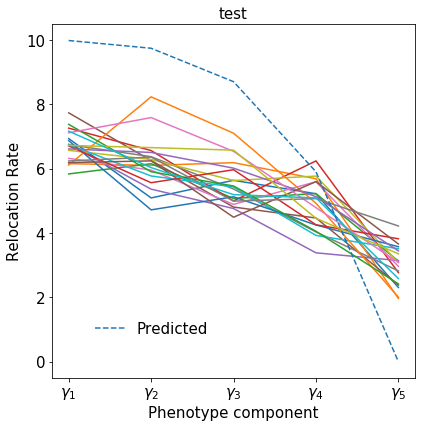

In [157]:
plotcopiesvariability(alldata=None,foodata=foo,copy=20,title="test")

In [8]:
alldata = [foo[i].result() for i in range(20)]

In [45]:
# data visualization function

def plotsingleviolin(data): # make violion plot for a single trail data
#     a =results2d128128cc1copies20with2000catast_nonoise[0].result()
    hop = np.zeros((5,500))
    for j in range(5):
        hop[j] = [data[i].__dict__['hop'][j] for i in range(len(data))]
    df = pd.DataFrame(hop.T,columns=(r'$S_1$',r'$S_2$',r'$S_3$',r'$S_4$',r'$S_5$'))
    fig, ax1 = plt.subplots()

    fsize = 12
    color = 'k'
    ax1.set_xlabel("Resource Level",fontsize = fsize)
    ax1.set_ylabel("Hopping Rate Distribution",color=color,fontsize = fsize)
    ax1.plot(df.median(),color=color,label='Simulated')

    sns.violinplot(data=df,scale='area',inner='box',cut=0, figsize=(20,20))
    #     plt.ylim(-0.5,10.5)
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_aspect(1/ax1.get_data_ratio())
    # ax1.set_ylim(-1.5,11.5)
    color = 'b'
    ax2 = fig.add_axes(ax1.get_position())
    ax2.set_facecolor("None")
    ax2.set_aspect('equal')
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(ax1.get_ylim())
    # ax2.plot([5,0],[0,2], color="red")
    #     ax2.plot(range(5),[10-10*(1-x)**4 for x in [4/5-b/5 for b in range(5)]],'--', color=color,label='Predicted')
    ax2.set_aspect(1/ax2.get_data_ratio())
    ax2.set_ylabel('Predicted Hopping Rate', color=color,fontsize = fsize)
    ax2.yaxis.set_label_position("right")
    ax2.yaxis.tick_right()
    ax2.tick_params(bottom=0, top=0, left=0, right=1, 
                    labelbottom=0, labeltop=0, labelleft=0, labelright=1,labelcolor=color)
    
def plotcopiesvariability(copy,title,alldata=None,foodata=None): #multi trails median plot
    if foodata!=None:    
        alldata = [foodata[i].result() for i in range(copy)];
    boxdata=[np.median(np.array([alldata[j][i].hop for i in range(500)]),axis=0) for j in range(copy)]
    for j in range(copy):
        plt.plot(range(1,6),boxdata[j])
    plt.xticks(np.arange(1,6), ('$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$',r'$\gamma_5$'),fontsize= 15)
    plt.ylabel('Relocation Rate',fontsize= 15)
    plt.xlabel('Phenotype component',fontsize= 15)
    plt.yticks(fontsize=15)
    plt.plot(range(1,6),[10-10*(x)**4 for x in [b/5 for b in range(1,6)]],'--',label='Predicted')
    plt.legend(loc='lower left', bbox_to_anchor=(0.08, 0.08),frameon=False,fontsize=15)
    fig = plt.gcf()
    fig.set_size_inches(6.5, 6.5)
    plt.title(title,fontsize= 15)
#     plt.savefig('{} catastrophes.pdf'.format(catastrophes))
    
def plotcopiesbox(copy,title,alldata=None,foodata=None): #multi trails box plot
    if foodata!=None:    
        alldata = [foodata[i].result() for i in range(copy)];
    boxdata=[np.median(np.array([alldata[j][i].hop for i in range(500)]),axis=0) for j in range(copy)]
    plt.boxplot([np.array(boxdata).T[i,:] for i in range(5)])
    plt.plot(range(1,6),[10-10*(x)**4 for x in [b/5 for b in range(1,6)]],'--',label='Predicted')
    plt.legend(loc='lower left', bbox_to_anchor=(0.08, 0.08),frameon=False,fontsize=15)
    plt.xticks(np.arange(1,6), ('$\gamma_1$',r'$\gamma_2$',r'$\gamma_3$',r'$\gamma_4$',r'$\gamma_5$'),fontsize= 15)
    plt.yticks(fontsize=15)
    plt.title(title,fontsize= 15)
    plt.ylabel('Relocation Rate',fontsize= 15)
    plt.xlabel('Phenotype component',fontsize= 15)
    fig = plt.gcf()
    fig.set_size_inches(6.5, 6.5)
#     plt.savefig('{} catastrophes_boxplot.pdf'.format(catastrophes))